In [1]:
import nibabel as nb
import numpy as np
from scipy import ndimage
from nilearn import plotting
import nilearn
import pandas as pd
import os
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import matplotlib.pyplot as plt

/home/tobywise/miniconda3/envs/toby/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Load ROIs

/home/tobywise/miniconda3/envs/toby/lib/python3.7/site-packages/numpy/ma/core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


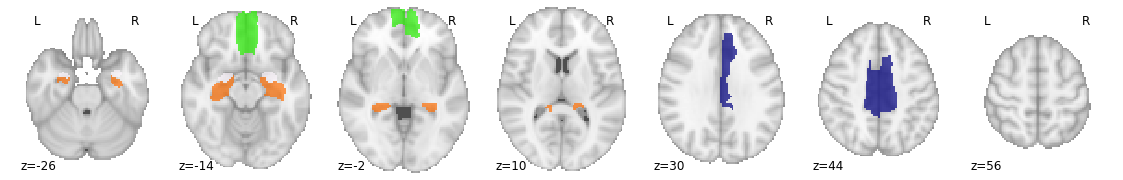

In [2]:
vmpfc_pcc_mask = nb.load('../data/vmpfc_mcc_mask.nii.gz')
plotting.plot_roi(vmpfc_pcc_mask, display_mode='z')

## Set up masker object

In [3]:
masker = NiftiLabelsMasker(labels_img='vmpfc_mcc_mask.nii.gz', standardize=False,
                           memory='nilearn_cache', verbose=0)

## Get data

In [4]:
nifti_dir = '../data/derivatives/rsa_revised/second_level/4d_niftis/'
images = os.listdir(nifti_dir)

result_dict = {'RDM': [], 'ROI': [], r'value': [], 'subject': []}

for i in images:
    if not 'diff' in i:
        print(i)
        img = nilearn.image.load_img(os.path.join(nifti_dir, i))
        extracted = masker.fit_transform(img)

        n_rows = np.product(extracted.shape)
        result_dict['RDM'] += [i] * n_rows
        result_dict['ROI'] +=  ['MCC', 'vmPFC', 'Hippocampus', 'Amygdala'] * int(n_rows / 4) 
        result_dict['subject'] += list(np.repeat(np.arange(int(n_rows / 4)), 4))
        result_dict['value'] += list(extracted.flatten())
        
result_dict = pd.DataFrame(result_dict)
result_dict.loc[result_dict['ROI'].str.contains('2611'), 'ROI'] = 'vmPFC'
result_dict.loc[result_dict['ROI'].str.contains('4011'), 'ROI'] = 'MCC'
result_dict['Patch'] = result_dict['RDM'].str.extract('([a-z]+(?=.nii.gz))')
result_dict['Patch'] = result_dict['Patch'].str.replace('alternative', 'Alternative')
result_dict['Patch'] = result_dict['Patch'].str.replace('current', 'Current')
result_dict['Variable'] = 'Social\ndensity'
result_dict.loc[result_dict['RDM'].str.contains('survival'), 'Variable'] = 'Socially\nadjusted\nvalue'

survival_value_current.nii.gz
threat.nii.gz
comp_alternative.nii.gz
comp_current.nii.gz
survival_value_alternative.nii.gz


In [5]:
result_dict[result_dict['Patch'] != 'threat'].to_csv('../data/derivatives/extracted_RSA_betas_revised.csv', index=False)
result_dict[result_dict['Patch'] == 'threat'].to_csv('../data/derivatives/extracted_RSA_betas_threat_revised.csv')

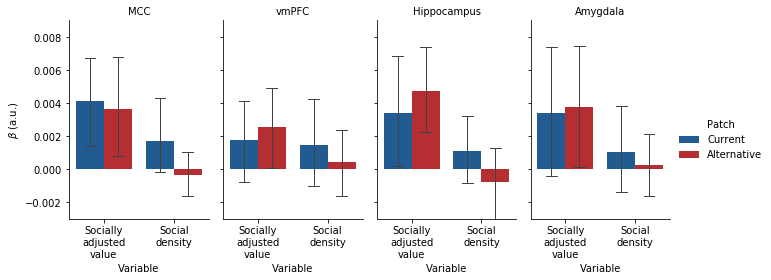

In [6]:
extracted = pd.read_csv('../data/derivatives/extracted_RSA_betas_revised.csv')
extracted = extracted.rename(columns={'value': r'$\beta$ (a.u.)'})
sns.catplot('Variable', r'$\beta$ (a.u.)', data=extracted, hue='Patch', col='ROI', 
            kind='bar', height=4, palette=['#105ba4ff', '#ca181dff'], aspect=.6,
            capsize=.15, errwidth=1).set_titles("{col_name}")
plt.ylim(-0.003, 0.009);

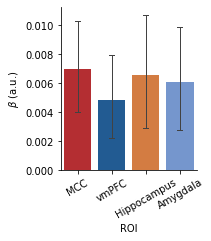

In [7]:
extracted = pd.read_csv('../data/derivatives/extracted_RSA_betas_threat_revised.csv')
extracted = extracted.rename(columns={'value': r'$\beta$ (a.u.)'})
sns.catplot('ROI', r'$\beta$ (a.u.)',  data=extracted,
            kind='bar', palette=['#ca181dff', '#105ba4ff', '#eb772a', '#6792db'], height=3, 
            capsize=.15, errwidth=1).set_titles("{col_name}").set_xticklabels(rotation=30)